# download packages

In [1]:
!pip install plotly

# Import the libraries

In [2]:
import numpy as np
import pandas as pd

import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
from keras.utils.np_utils import to_categorical
InteractiveShell.ast_node_interactivity = "all"
from keras.layers.advanced_activations import LeakyReLU

# prepare train test splits

In [3]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
#     # Prepare data for training and testing the model
#     train_datagen = ImageDataGenerator(rescale = 1./255,
#                                   rotation_range = 10,
#                                   width_shift_range = 0.2,
#                                   height_shift_range = 0.2,
#                                   shear_range = 0.2,
#                                   horizontal_flip = True,
#                                   vertical_flip = True,
#                                   fill_mode = 'nearest')
#     train_datagen.fit(X_train)
#     test_datagen = ImageDataGenerator(rescale = 1./255)
#     test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# read the data

In [4]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [5]:
data = pd.read_csv(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/",'HAM10000_metadata.csv'))

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [6]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [8]:
data.isnull().any().sum()

1

# Imputing the Null values and preparing the data

In [9]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [10]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [11]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

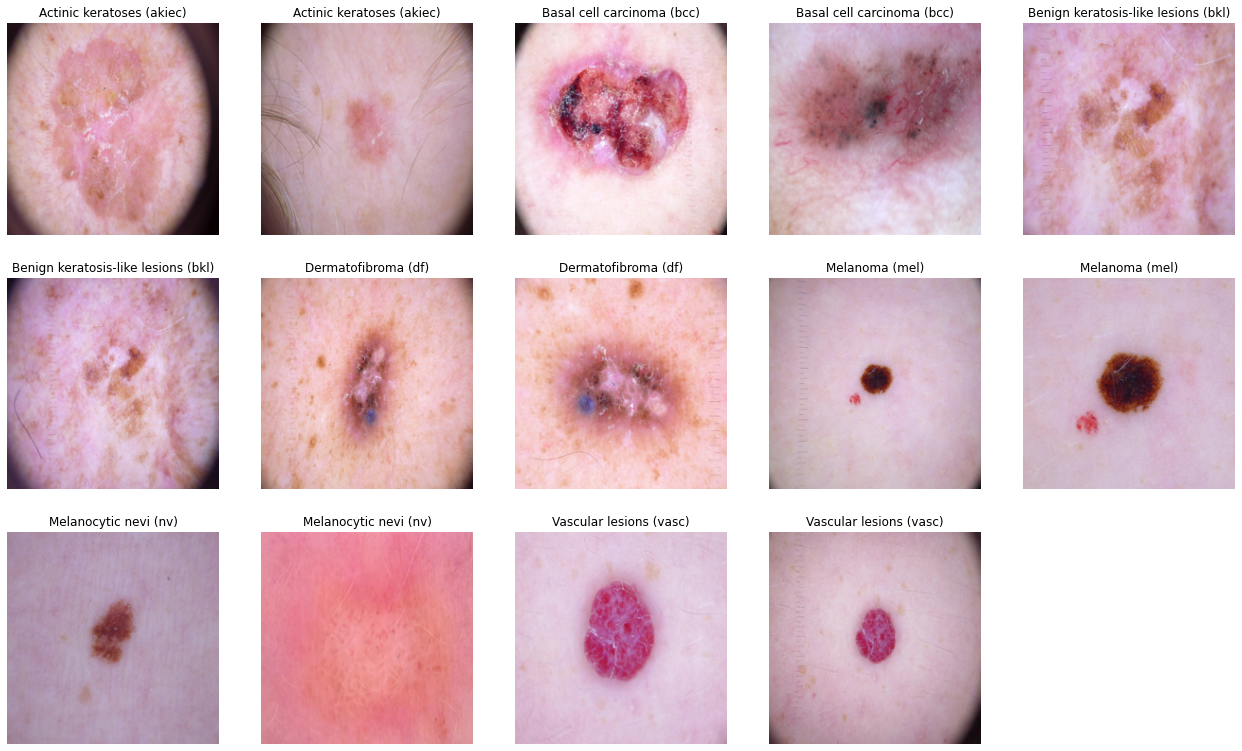

In [12]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [13]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [14]:
print(data.shape)

(10015, 12)


In [15]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = to_categorical(np.array(data.iloc[:, -1:]), num_classes = 7)
print(X_orig.shape)
print(Y_orig.shape)

(10015, 224, 224, 3)
(10015, 7)


In [16]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

Augmentation


In [17]:
# # With data augmentation to prevent overfitting 

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # apply ZCA whitening
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#         horizontal_flip=True,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(X_train_orig)

# CNN Model

In [18]:
model = Sequential()

# Convolutional layer 1
model.add(Conv2D(64,(3,3), input_shape=(224, 224, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional layer 2
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 3
model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 4
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

 # Convolutional layer 5
model.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 6
model.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Full connect layers

model.add(Dense(units= 1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=7, activation='softmax'))



model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

model.summary()

2022-04-27 23:19:12.389532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 23:19:12.394740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 23:19:12.395485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 23:19:12.396640: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       1

In [19]:
model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 7, verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model_mcp = ModelCheckpoint(filepath = 'CNN_model_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history = model.fit(X_train_orig, Y_train_orig, epochs=30, validation_data=(X_test_orig,Y_test_orig), 
                      steps_per_epoch=5712//32, validation_steps= 1311//32,
                      callbacks=[model_es, model_rlr, model_mcp])

2022-04-27 23:19:15.192112: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1206030336 exceeds 10% of free system memory.
2022-04-27 23:19:16.483207: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1206030336 exceeds 10% of free system memory.
2022-04-27 23:19:17.410010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-27 23:19:19.282695: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


178/178 [==============================] - ETA: 0s - loss: 1.0905 - categorical_accuracy: 0.6573

2022-04-27 23:19:48.471311: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301507584 exceeds 10% of free system memory.
2022-04-27 23:19:48.814796: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301507584 exceeds 10% of free system memory.


178/178 [==============================] - 37s 157ms/step - loss: 1.0905 - categorical_accuracy: 0.6573 - val_loss: 1.0574 - val_categorical_accuracy: 0.6835

Epoch 00001: val_categorical_accuracy improved from -inf to 0.68347, saving model to CNN_model_weights.h5
Epoch 2/30
178/178 [==============================] - 23s 129ms/step - loss: 0.7924 - categorical_accuracy: 0.7193 - val_loss: 0.7448 - val_categorical_accuracy: 0.7229

Epoch 00002: val_categorical_accuracy improved from 0.68347 to 0.72292, saving model to CNN_model_weights.h5
Epoch 3/30
178/178 [==============================] - 23s 129ms/step - loss: 0.6963 - categorical_accuracy: 0.7439 - val_loss: 0.7208 - val_categorical_accuracy: 0.7334

Epoch 00003: val_categorical_accuracy improved from 0.72292 to 0.73340, saving model to CNN_model_weights.h5
Epoch 4/30
178/178 [==============================] - 23s 129ms/step - loss: 0.6457 - categorical_accuracy: 0.7679 - val_loss: 0.6361 - val_categorical_accuracy: 0.7614

Epoch 0

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Proposed CNN Model Accuracy')

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Proposed CNN Model Loss')

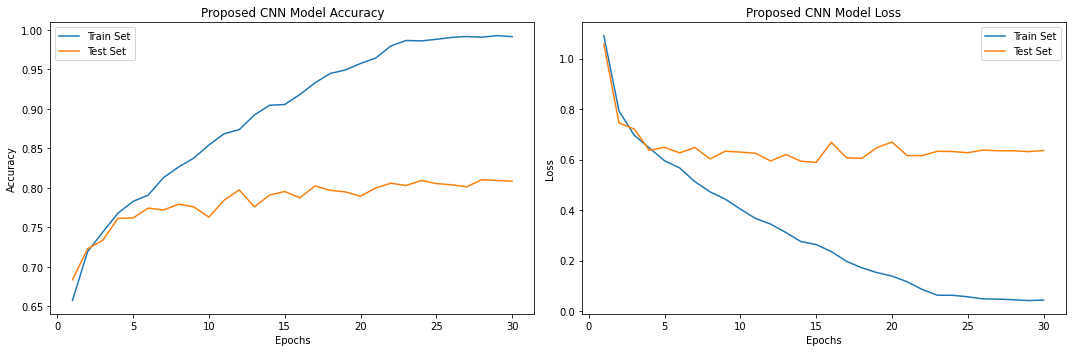

In [20]:
# plot model performance
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Proposed CNN Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Proposed CNN Model Loss')

plt.tight_layout()
plt.show()

# VGG Model

In [21]:
from keras.applications.vgg16 import VGG16, preprocess_input

In [22]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=(224,224,3)
)

In [23]:
NUM_CLASSES = 7

vgg16 = Sequential()
vgg16.add(vgg16_base_model)
vgg16.add(Flatten())
vgg16.add(Dropout(0.5))
vgg16.add(Dense(NUM_CLASSES, activation='softmax'))

vgg16.layers[0].trainable = False

vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 175623    
Total params: 14,890,311
Trainable params: 175,623
Non-trainable params: 14,714,688
_________________________________________________________________


In [24]:
history2 = vgg16.fit(X_train_orig, Y_train_orig, epochs=30, validation_data=(X_test_orig,Y_test_orig), 
                      steps_per_epoch=5712//32, validation_steps= 1311//32,
                      callbacks=[model_es, model_rlr])

2022-04-27 23:32:05.868540: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1206030336 exceeds 10% of free system memory.


Epoch 1/30
178/178 [==============================] - 29s 144ms/step - loss: 4.7994 - accuracy: 0.5694 - val_loss: 2.7081 - val_accuracy: 0.6950
Epoch 2/30
178/178 [==============================] - 19s 110ms/step - loss: 3.3567 - accuracy: 0.6364 - val_loss: 2.1771 - val_accuracy: 0.7124
Epoch 3/30
178/178 [==============================] - 20s 110ms/step - loss: 2.7113 - accuracy: 0.6710 - val_loss: 2.2848 - val_accuracy: 0.7279
Epoch 4/30
178/178 [==============================] - 19s 109ms/step - loss: 2.1606 - accuracy: 0.6993 - val_loss: 2.0475 - val_accuracy: 0.7374
Epoch 5/30
178/178 [==============================] - 20s 110ms/step - loss: 1.8752 - accuracy: 0.7202 - val_loss: 1.8526 - val_accuracy: 0.7404
Epoch 6/30
178/178 [==============================] - 19s 110ms/step - loss: 1.5705 - accuracy: 0.7454 - val_loss: 2.1126 - val_accuracy: 0.7439
Epoch 7/30
178/178 [==============================] - 20s 110ms/step - loss: 1.3626 - accuracy: 0.7654 - val_loss: 1.7523 - val_ac

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, ' VGG-16 Model Accuracy')

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'VGG-16 Model Loss')

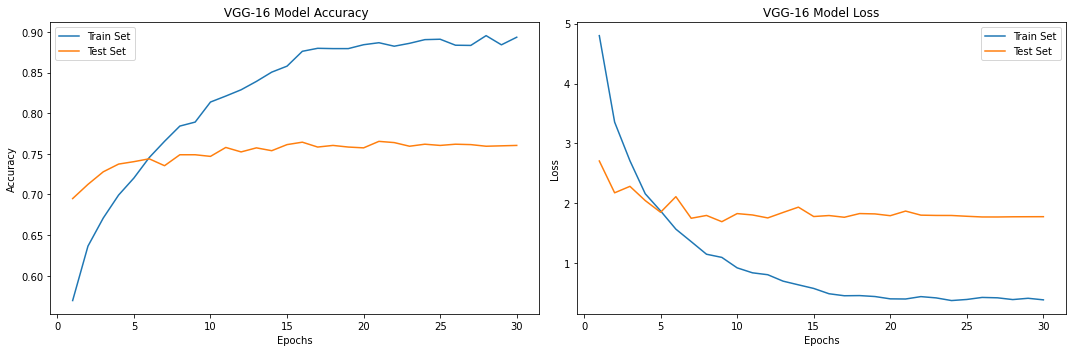

In [25]:
# plot VGG model performance
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(1, len(history2.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(' VGG-16 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Model Loss')

plt.tight_layout()
plt.show()

# Xception Model

In [26]:
#Xception
xception_weight_path = '../input/keras-pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
xception_base_model = tf.keras.applications.Xception(
    include_top=False,
    weights=xception_weight_path,
    input_shape=(224,224,3),
)

In [27]:
NUM_CLASSES = 7

xception = Sequential()
xception.add(xception_base_model)
xception.add(Flatten())
xception.add(Dropout(0.5))
xception.add(Dense(NUM_CLASSES, activation='softmax'))

xception.layers[0].trainable = False

xception.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

xception.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 702471    
Total params: 21,563,951
Trainable params: 702,471
Non-trainable params: 20,861,480
_________________________________________________________________


In [28]:
history3 = xception.fit(X_train_orig, Y_train_orig, epochs=30, validation_data=(X_test_orig,Y_test_orig), 
                      steps_per_epoch=5712//32, validation_steps= 1311//32,
                      callbacks=[model_es, model_rlr])

Epoch 1/30
178/178 [==============================] - 28s 141ms/step - loss: 41.7778 - accuracy: 0.5663 - val_loss: 28.3207 - val_accuracy: 0.7074
Epoch 2/30
178/178 [==============================] - 23s 130ms/step - loss: 35.7814 - accuracy: 0.5984 - val_loss: 17.6328 - val_accuracy: 0.7029
Epoch 3/30
178/178 [==============================] - 23s 130ms/step - loss: 33.4905 - accuracy: 0.6096 - val_loss: 23.6862 - val_accuracy: 0.6760
Epoch 4/30
178/178 [==============================] - 23s 130ms/step - loss: 32.0410 - accuracy: 0.6194 - val_loss: 18.6725 - val_accuracy: 0.5901
Epoch 5/30
178/178 [==============================] - 23s 130ms/step - loss: 29.8280 - accuracy: 0.6218 - val_loss: 16.2791 - val_accuracy: 0.6960
Epoch 6/30
178/178 [==============================] - 23s 130ms/step - loss: 29.1479 - accuracy: 0.6274 - val_loss: 19.0416 - val_accuracy: 0.6365
Epoch 7/30
178/178 [==============================] - 23s 129ms/step - loss: 27.6490 - accuracy: 0.6388 - val_loss: 24

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Xception Model Accuracy')

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Xception Model Loss')

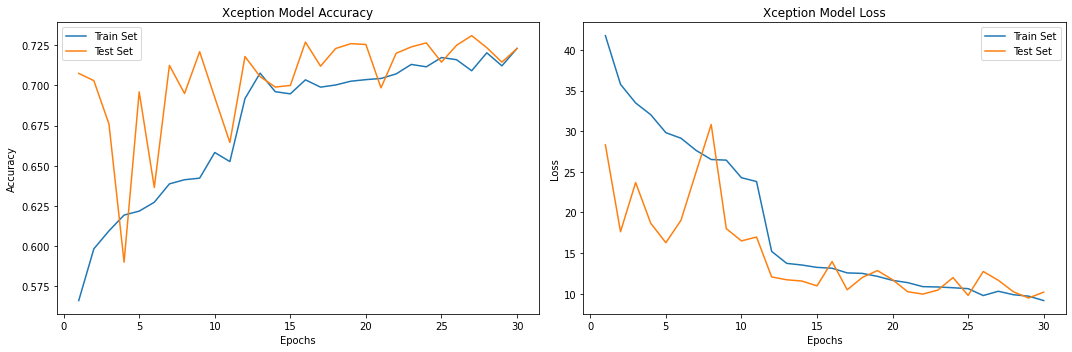

In [29]:
# plot Xception model performance
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs_range = range(1, len(history3.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Xception Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Xception Model Loss')

plt.tight_layout()
plt.show()

# Resnet-50 Model

In [30]:
resnet50_base_model= ResNet50(
    input_shape=(224,224,3), 
    include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [31]:
NUM_CLASSES = 7
resnet50=Sequential()
resnet50.add(resnet50_base_model)
resnet50.add(Flatten())
resnet50.add(BatchNormalization())
resnet50.add(Dense(256,kernel_initializer='he_uniform'))
resnet50.add(BatchNormalization())
resnet50.add(Dropout(0.5))
resnet50.add(Dense(NUM_CLASSES,activation='softmax'))

for layer in resnet50_base_model.layers:
    layer.trainable = False

    
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

resnet50.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 100352)            401408    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25690368  
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 7)                

In [32]:
import gc
gc.collect()

8695

In [33]:
history4 = resnet50.fit(X_train_orig, Y_train_orig, epochs=30, validation_data=(X_test_orig,Y_test_orig), 
                      steps_per_epoch=5712//32, validation_steps= 1311//32,
                      callbacks=[model_es, model_rlr])

Epoch 1/30
178/178 [==============================] - 23s 110ms/step - loss: 1.5466 - accuracy: 0.6085 - val_loss: 0.8174 - val_accuracy: 0.7549
Epoch 2/30
178/178 [==============================] - 17s 98ms/step - loss: 0.5737 - accuracy: 0.8206 - val_loss: 0.7633 - val_accuracy: 0.7828
Epoch 3/30
178/178 [==============================] - 17s 98ms/step - loss: 0.3041 - accuracy: 0.9038 - val_loss: 0.8818 - val_accuracy: 0.7708
Epoch 4/30
178/178 [==============================] - 18s 99ms/step - loss: 0.1687 - accuracy: 0.9477 - val_loss: 0.9931 - val_accuracy: 0.7743
Epoch 5/30
178/178 [==============================] - 17s 98ms/step - loss: 0.0999 - accuracy: 0.9699 - val_loss: 1.0139 - val_accuracy: 0.7748
Epoch 6/30
178/178 [==============================] - 17s 98ms/step - loss: 0.0923 - accuracy: 0.9719 - val_loss: 1.2612 - val_accuracy: 0.7664
Epoch 7/30
178/178 [==============================] - 17s 98ms/step - loss: 0.0983 - accuracy: 0.9720 - val_loss: 1.1976 - val_accuracy

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'ResNet50 Model Accuracy')

<AxesSubplot:>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'ResNet50 Model Loss')

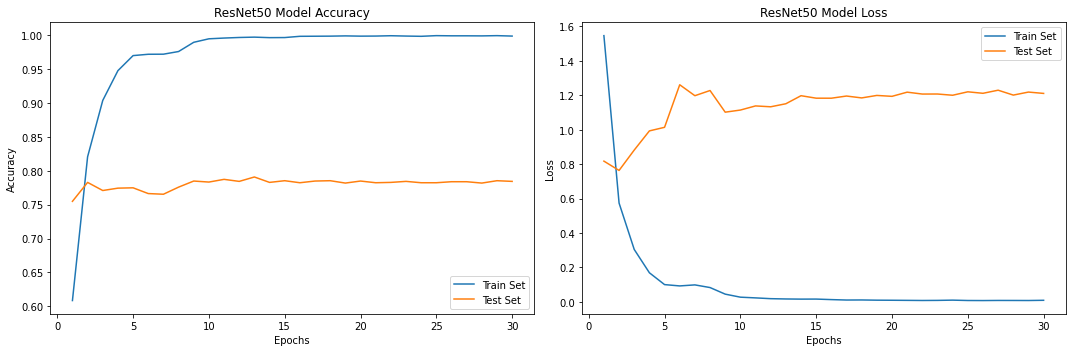

In [34]:
# plot ResNet50 model performance
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs_range = range(1, len(history4.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet50 Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Model Loss')

plt.tight_layout()
plt.show()

# Evaluating CNN Model, VGG 16, Xception and Resnet-50

(-0.1, 12.0)

Text(0.5, 1.0, 'Loss on The Proposed CNN Model')

(0.4, 1.0)

Text(0.5, 1.0, 'Accuracy on The Proposed CNN Model')

(-0.1, 12.0)

Text(0.5, 1.0, 'Loss on VGG16')

(0.4, 1.0)

Text(0.5, 1.0, 'Accuracy on VGG16')

(-0.1, 12.0)

Text(0.5, 1.0, 'Loss on Xception')

(0.4, 1.0)

Text(0.5, 1.0, 'Accuracy on Xception')

(-0.1, 12.0)

Text(0.5, 1.0, 'Loss on Resnet-50')

(0.4, 1.0)

Text(0.5, 1.0, 'Accuracy on Resnet-50')

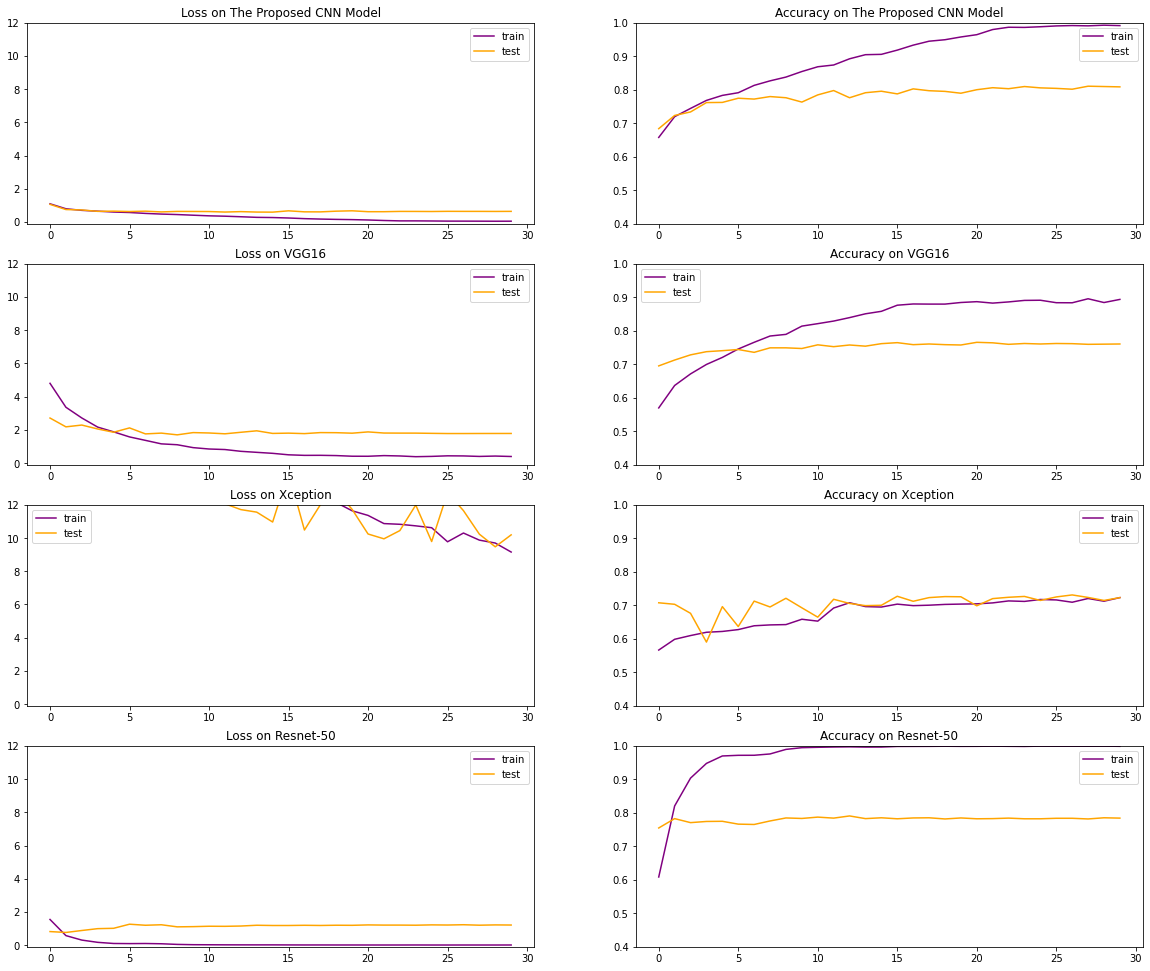

In [35]:
# Code for plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 2, figsize=(20,17))

axs[0, 0].plot(history.history["loss"],c = "purple")
axs[0, 0].plot(history.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([-0.1,12])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Loss on The Proposed CNN Model')

axs[0, 1].plot(history.history["categorical_accuracy"],c = "purple")
axs[0,1].plot(history.history["val_categorical_accuracy"],c = "orange")
axs[0, 1].set_ylim([0.4,1.0])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Accuracy on The Proposed CNN Model')

axs[1, 0].plot(history2.history["loss"],c = "purple")
axs[1, 0].plot(history2.history["val_loss"],c = "orange")
axs[1, 0].set_ylim([-0.1,12])
axs[1, 0].legend(["train", "test"])
axs[1, 0].set_title('Loss on VGG16')

axs[1, 1].plot(history2.history["accuracy"],c = "purple")
axs[1, 1].plot(history2.history["val_accuracy"],c = "orange")
axs[1, 1].set_ylim([0.4,1.0])
axs[1, 1].legend(["train", "test"])
axs[1, 1].set_title('Accuracy on VGG16')

axs[2, 0].plot(history3.history["loss"],c = "purple")
axs[2, 0].plot(history3.history["val_loss"],c = "orange")
axs[2, 0].set_ylim([-0.1,12])
axs[2, 0].legend(["train", "test"])
axs[2, 0].set_title('Loss on Xception')

axs[2, 1].plot(history3.history["accuracy"],c = "purple")
axs[2, 1].plot(history3.history["val_accuracy"],c = "orange")
axs[2, 1].set_ylim([0.4,1.0])
axs[2, 1].legend(["train", "test"])
axs[2, 1].set_title('Accuracy on Xception')

axs[3, 0].plot(history4.history["loss"],c = "purple")
axs[3, 0].plot(history4.history["val_loss"],c = "orange")
axs[3, 0].set_ylim([-0.1,12])
axs[3, 0].legend(["train", "test"])
axs[3, 0].set_title('Loss on Resnet-50')

axs[3, 1].plot(history4.history["accuracy"],c = "purple")
axs[3, 1].plot(history4.history["val_accuracy"],c = "orange")
axs[3, 1].set_ylim([0.4,1.0])
axs[3, 1].legend(["train", "test"])
axs[3, 1].set_title('Accuracy on Resnet-50')